In [136]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image
import scipy.sparse as sp
import time
import itertools
import scipy
import cvxpy as cp
import random
import matplotlib
import math

class Genetic_Algorithm:
    def __init__(self, beta, img_list):
        
        self.beta = beta
        self.N = img_list[0].shape[0]
        self.imgs = [img.flatten() for img in img_list]
        self.b_eq = np.concatenate(self.imgs)
        self.non_zero_indices = []
        self.n_imgs = len(self.imgs)
        
        start = time.time()
        print("initializing omega...")
        self.current_gamma, self.active_indices = self.initialize_omega()
        print("omega initialized in %5.3f. s" %(time.time()-start))
        
        start = time.time()
        print("initializing cost vector...")
        self.current_cost_vector = self.get_cost(self.active_indices)
        print("cost vector initialized in %5.3f. s" %(time.time()-start))
       
        start = time.time()
        print("initializing full model...")
        self.current_gamma, self.constraints_RMP, self.current_kantorovich = self.initialize_model()
        print("full model initialized in %5.3f. s" %(time.time()-start))

        #stats
        self.cost = []
        self.time_child = []
        self.children_sampled = []
        self.time_model = []
        self.len_children = []
        
    def initialize_omega(self):
        #the north west rule is used to initialise omega
        #we start with the first pixel of each image
        indices = np.zeros(self.n_imgs)
        omega = [indices.copy()]
        b = np.array([img[0] for img in self.imgs])

        current_gamma = [np.min(b)]
        while np.min(indices) < self.N**2-1:
            gamma = np.min(b)
            b-=gamma
            for i in range(self.n_imgs):
                if math.isclose(b[i], 0, abs_tol=1e-14):
                    if indices[i]==self.N**2-1:
                        continue
                    indices[i]+=1
                    b[i]+= self.imgs[i][indices[i].astype('int')]
            omega.append(indices.copy())
            current_gamma.append(gamma)
        
        return np.array(current_gamma), np.array(omega).astype('int')
        
    def initialize_model(self):
        indices_row = np.array([])
        indices_col = np.array([])
        for i in range(self.n_imgs):
            for indices in range(self.N**2):
                gamma_indices = np.where(self.active_indices.transpose()[i] == indices)[0]
                indices_row = np.concatenate((indices_row, gamma_indices))
                indices_col = np.concatenate((indices_col, np.ones(len(gamma_indices))*(indices+i*self.N**2)))

        A_eq = sp.csr_matrix((np.ones(len(indices_col)), (indices_col, indices_row)), shape=( self.N**2*self.n_imgs, len(self.active_indices)))
        
        gamma = cp.Variable(len(self.current_cost_vector))
        
        objective = cp.Minimize(self.current_cost_vector @ gamma)
       
        constraints = [A_eq @ gamma == self.b_eq, gamma >= 0]
        #print("eq,constraint ######## ")
        #print(A_eq)
        #print(constraints)
        #print("#########")
        prob = cp.Problem(objective, constraints)
        gamma.value = self.current_gamma
        prob.solve(warm_start = True, solver=cp.GUROBI)
        
        primal_solution = gamma.value
        dual_solution = -constraints[0].dual_value
        return primal_solution, A_eq, dual_solution

    def barycentric_distance(self, indices_list):
        # mean squared deviation from the classical barycenter of the xi
        #rescale x and y to be in [0,1]
        indices_list=indices_list/self.N
        barycenter = np.sum(indices_list, axis=0)/self.n_imgs
        barycenter_cost = np.sum([np.sum((x - barycenter) ** 2, axis=0)/self.n_imgs for x in indices_list], axis=0)
        return barycenter_cost

    def get_cost(self, vector):
        #for each pair of active pixels, compute the cost of moving the first pixel to the second
        indices_list = []
        for i in range(self.n_imgs):
            indices_list.append(np.array(np.unravel_index(vector.transpose()[i], (self.N, self.N))))
        #print("indices #####")
        #print(indices_list)
        #print("#########")
        cost_vector = self.barycentric_distance(np.array(indices_list))
        return cost_vector

    def compute_gain(self, cost, children):
        gain = np.sum([self.current_kantorovich[i*self.N**2:(i+1)*self.N**2][children.transpose()[i]] for i in range(self.n_imgs)])-cost
        return gain

    def find_best_child(self):
        parent = self.non_zero_indices.copy().transpose()
        
        index = random.randint(0,self.n_imgs-1)
        parent[index] = np.random.randint(0, self.N**2, size=len(parent[1]))
        children = parent.copy().transpose()
        
        gain = self.compute_gain(self.get_cost(children), children)
        best_children = children[np.where(gain > 0)[0]]
       
        return best_children

    
    def get_single_cost(self, child):
        indices = np.array([np.array(np.unravel_index(child[0], (self.N, self.N))) for i in range(self.n_imgs)])
        return self.barycentric_distance(indices)

    
    def run(self, max_iter, max_sample, max_runtime):
        start_runtime = time.time()
        for _ in tqdm(range(max_iter)):
            if time.time() - start_runtime > max_runtime:
                break
            start = time.time()
            self.non_zero_indices = self.active_indices[np.nonzero(self.current_gamma)]
            sample = 0
            #divide the non zero indices into chunks of size chunk_size
            best_children = self.find_best_child()
            while best_children.shape[0] == 0 and sample < max_sample:
                sample += len(self.non_zero_indices)
                best_children = self.find_best_child()

            self.children_sampled.append(sample)
            self.time_child.append(time.time() - start)

            self.current_cost_vector = np.append(self.current_cost_vector, self.get_cost(best_children))
            self.current_gamma = np.append(self.current_gamma, np.zeros(best_children.shape[0]))
            for child in best_children:
                 self.active_indices = np.vstack((self.active_indices, child))
                 children = self.active_indices[-1]
                 A_col = np.zeros(self.N**2*self.n_imgs)
                 children_idx = [i*self.N**2+children[i] for i in range(self.n_imgs)]
                 A_col[children_idx] = 1
                 self.constraints_RMP = sp.hstack((self.constraints_RMP, A_col.reshape(-1,1)))

            if self.active_indices.shape[0] > int(self.beta*(self.N**2*self.n_imgs)):
                
                zero_indices = np.where(self.current_gamma == 0)[:int((beta-1)*(self.N**2*self.n_imgs))]
                self.active_indices = np.delete(self.active_indices, zero_indices, axis=0)
                self.current_cost_vector = np.delete(self.current_cost_vector, zero_indices)
                self.current_gamma = np.delete(self.current_gamma, zero_indices)
                self.current_gamma, self.constraints_RMP, self.current_kantorovich = self.initialize_model()
                continue

            self.solve_model()



    def solve_model(self):
        start = time.time()

        A_eq = self.constraints_RMP
        gamma = cp.Variable(len(self.current_cost_vector))
        prob = cp.Problem(cp.Minimize(self.current_cost_vector @ gamma), [A_eq @ gamma == self.b_eq, gamma >= 0])
        gamma.value = self.current_gamma
        prob.solve(warm_start=True, solver=cp.GUROBI, verbose=False)

        primal_solution = gamma.value
        dual_solution = -prob.constraints[0].dual_value
        self.cost.append(prob.value)
        self.time_model.append(time.time()-start)
        self.current_gamma = primal_solution
        self.current_kantorovich = dual_solution

    def get_mean(self, par):
        
        indices = np.array([[np.unravel_index(self.active_indices.transpose()[i], (self.N, self.N))[j] for i in range(self.n_imgs)] for j in range(2)]) 
        indices = indices.transpose((1,0,2))
        mean = [np.sum([par[i]*indices[i][j] for i in range(self.n_imgs)], axis=0).astype('int') for j in range(2)]        
        mean = np.ravel_multi_index(mean, (self.N, self.N))
        gamma = sp.csr_matrix((self.current_gamma, (self.active_indices.transpose()[0], mean)),
                              shape=(self.N ** 2, self.N ** 2))
        return 1-gamma.todense().transpose().dot(self.imgs[0]).reshape(self.N, self.N)

    def reduce(self):
        non_zero_indices = np.where(self.current_gamma != 0)[0]
        self.active_indices = self.active_indices[non_zero_indices]
        self.current_cost_vector = self.current_cost_vector[non_zero_indices]
        self.current_gamma = self.current_gamma[non_zero_indices]

    def plot(self):
        if self.n_imgs==2:
            plt.close()
            fig, axs = plt.subplots(2, 6)
            axs[0][0].imshow(self.get_mean(1), cmap='gray')
            axs[0][1].imshow(self.get_mean(0.95), cmap='gray')
            axs[0][2].imshow(self.get_mean(0.9), cmap='gray')
            axs[0][3].imshow(self.get_mean(0.8), cmap='gray')
            axs[0][4].imshow(self.get_mean(0.7), cmap='gray')
            axs[0][5].imshow(self.get_mean(0.6), cmap='gray')
            axs[1][0].imshow(self.get_mean(0.5), cmap='gray')
            axs[1][1].imshow(self.get_mean(0.4), cmap='gray')
            axs[1][2].imshow(self.get_mean(0.3), cmap='gray')
            axs[1][3].imshow(self.get_mean(0.2), cmap='gray')
            axs[1][4].imshow(self.get_mean(0.1), cmap='gray')
            axs[1][5].imshow(self.get_mean(0), cmap='gray')
            plt.show()
        if self.n_imgs==3:
            plt.close()
            fig, axs = plt.subplots(4, 4)
            axs[0][0].imshow(self.get_mean((1,0,0)), cmap='gray')
            axs[0][1].imshow(self.get_mean((0.67,0.33,0)), cmap='gray')
            axs[0][2].imshow(self.get_mean((0.37,0.63,0)), cmap='gray')
            axs[0][3].imshow(self.get_mean((0,1,0)), cmap='gray')
            axs[1][0].imshow(self.get_mean((0.67,0,0.33)), cmap='gray')
            axs[1][1].imshow(self.get_mean((0.5,0.25,0.25)), cmap='gray')
            axs[1][2].imshow(self.get_mean((0.25,0.5,0.25)), cmap='gray')
            axs[2][0].imshow(self.get_mean((0.33,0,0.67)), cmap='gray')
            axs[2][1].imshow(self.get_mean((0.25,0.25,0.5)), cmap='gray')
            axs[3][0].imshow(self.get_mean((0,0,1)), cmap='gray')  
            plt.show()
        if self.n_imgs>3:
            plt.close()
            fig, axs =plt.subplots(1,self.n_imgs+1)
            for i in range(self.n_imgs):
                axs[i].imshow(1-self.imgs[i].reshape(self.N,self.N), cmap='gray')
            axs[self.n_imgs].imshow(self.get_mean(tuple([1/self.n_imgs])*self.n_imgs), cmap='gray')
            plt.show()
            
    def save(self):
        matplotlib.image.imsave('barycenter.png', self.get_mean(0.5), cmap='Greys')

 

In [137]:
dim=5
n_imgs = 2
#img_list = [np.random.random([dim,dim]) for i in range(n_imgs)]
path_img1 = "dolphin_64.jpg"
path_img2 = "bird_64.jpg"
path_img3 = "star_64.jpg"
path_img4 = "flower_64.jpg"

paths = [path_img1,path_img2,path_img3,path_img4]

img_list = [np.array(Image.open(path).convert('L')) for path in paths]

img_list = [1-img/255 for img in img_list]
img_list = [(img/np.sum(img))*img.shape[0] for img in img_list]

beta = 2.3  # hyperparameter
ga = Genetic_Algorithm(beta=beta, img_list=img_list)


initializing omega...
omega initialized in 0.180. s
initializing cost vector...
cost vector initialized in 0.001. s
initializing full model...
full model initialized in 1.087. s


In [138]:
ga.run(max_iter=500, max_sample=1000, max_runtime=10)

  0%|▏                                            | 2/500 [00:11<46:19,  5.58s/it]


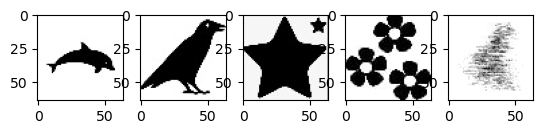

In [139]:
ga.plot()

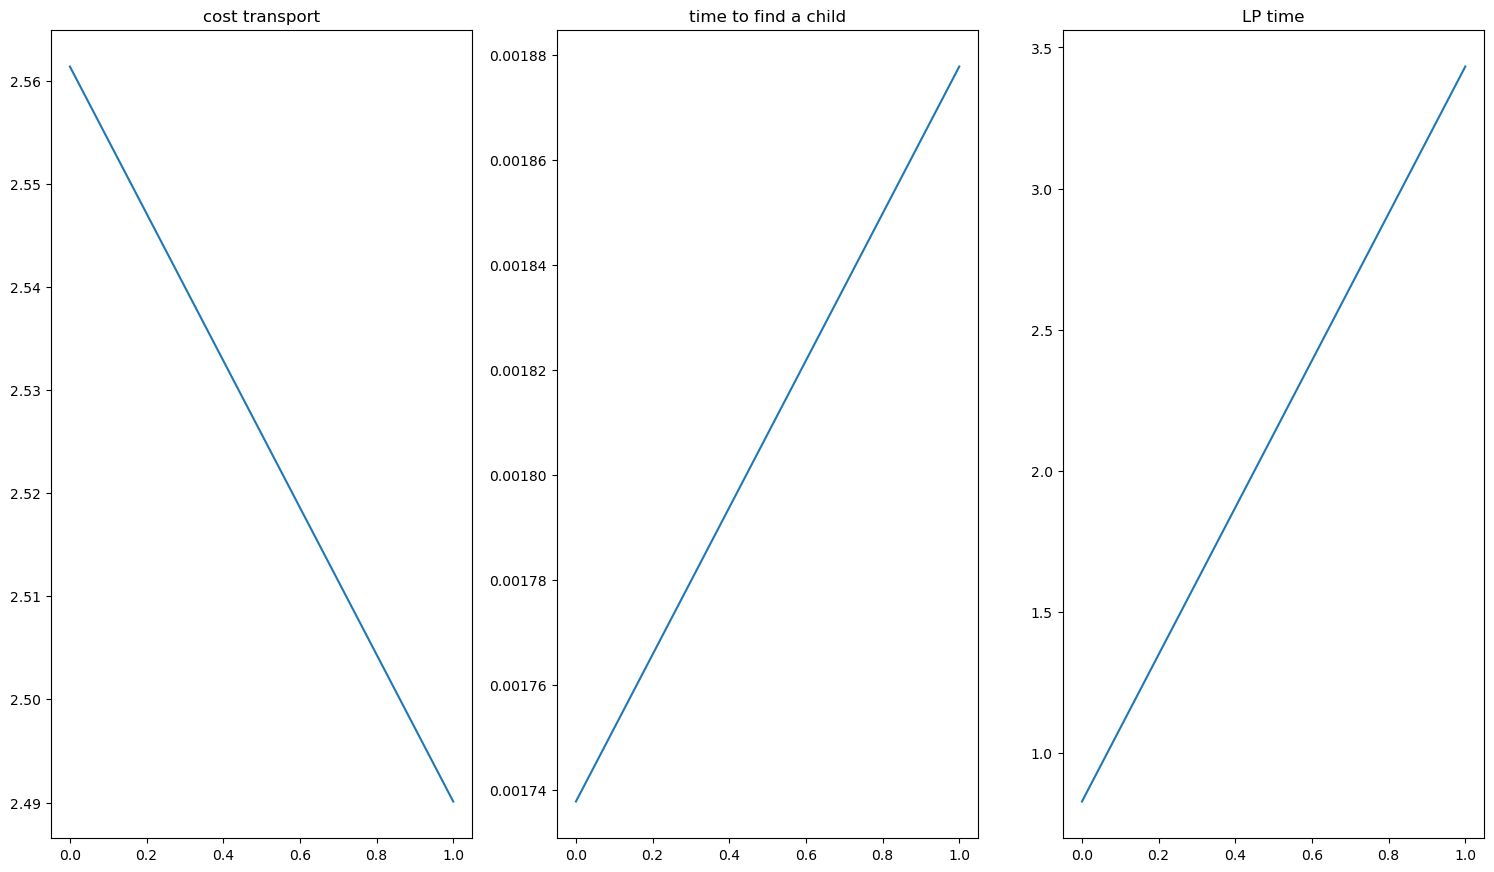

the final cost is 2.4901007650248994


In [141]:
figure, axis = plt.subplots(1, 3)

axis[0].plot(ga.cost)
axis[0].set_title("cost transport")
#axis[0].set_ylim((0, 2))

axis[1].plot(ga.time_child)
axis[1].set_title("time to find a child")
#axis[1].set_ylim((0, 0.01))
  
axis[2].plot(ga.time_model)
axis[2].set_title("LP time")
#axis[2].set_ylim((0, 0.5))

figure.set_size_inches(18.5, 10.5)

plt.show()

print(f"the final cost is {ga.cost[-1]}")